<a href="https://colab.research.google.com/github/santiagomangone/RN2-TPs/blob/main/TP2-%20Attention/Attention_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de texto

Utilizaremos el dataset Twenty News Groups

La siguiente notebook tiene como finalidad realizar una clasificacion de un texto entre las 20 posibles categorías valiendonos de diferentes arquitecturas para redes neuronales y, principalmente, observar como afecta y si es que mejoran la performance de la tarea el mecanismo de "Attention"

In [2]:
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
from collections import Counter
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
import numpy as np
import gensim
import os, re, csv, math, codecs

Vemos las clases de los articulos del dataset, entre las cuales los modelos deberan discernir a cual pertenece el texto de entrada, una vez entrenadas.

In [3]:
from pprint import pprint
pprint(newsgroups_train.target_names)
pprint(newsgroups_train.target)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']
array([7, 4, 4, ..., 3, 1, 8])


Visualizamos un ejemplo de un texto.

In [4]:
print(newsgroups_train.data[16])

From: ab@nova.cc.purdue.edu (Allen B)
Subject: Re: TIFF: philosophical significance of 42
Organization: Purdue University
Lines: 39

In article <prestonm.735400848@cs.man.ac.uk> prestonm@cs.man.ac.uk (Martin  
Preston) writes:
> Why not use the PD C library for reading/writing TIFF files? It took me a
> good 20 minutes to start using them in your own app.

I certainly do use it whenever I have to do TIFF, and it usually works
very well.  That's not my point.  I'm >philosophically< opposed to it
because of its complexity.

This complexity has led to some programs' poor TIFF writers making
some very bizarre files, other programs' inability to load TIFF
images (though they'll save them, of course), and a general
inability to interchange images between different environments
despite the fact they all think they understand TIFF.

As the saying goes, "It's not me I'm worried about- it's all the
>other<  assholes out there!"  I've had big trouble with misuse and
abuse of TIFF over the years, 

###Instanciamos nuestro tokenizador

In [5]:
token=Tokenizer(num_words=30000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token="UNK", document_count=0)

Notar que el parametro "char_level" se elige dejar en false, ya que para este caso no pretendemos trabajar a nivel caracter, sino que a nivel palabra. Esto es asi ya que, para esta tarea no es necesario ni deseable trabajar con letras, sino con palabras. Un ejemplo en el que si podria ser util este approach es en el caso de predicción de la palabra completa (sistema de auto-fill) o bien, en algunos casos, para un LLM.

###Y fiteamos a nuestra data.
Primero se tokenizan las palabras y luego las oraciones/secuencias

In [6]:
token.fit_on_texts(newsgroups_train.data)

In [7]:
train_sequences=token.texts_to_sequences(newsgroups_train.data)
test_sequences=token.texts_to_sequences(newsgroups_test.data)


Asi queda un texto tokenizado

In [8]:
train_sequences[0]

[15,
 1,
 4309,
 1351,
 16,
 11127,
 39,
 251,
 30,
 43,
 299,
 10,
 18,
 96,
 79,
 92,
 23734,
 4309,
 1351,
 16,
 35,
 78,
 4,
 2953,
 611,
 1768,
 33,
 212,
 9,
 27,
 1309,
 28,
 172,
 67,
 48,
 124,
 9880,
 64,
 17,
 18,
 299,
 9,
 709,
 2,
 87,
 264,
 12,
 27,
 5,
 37,
 1498,
 2267,
 299,
 1163,
 3,
 19,
 15,
 2,
 1348,
 13638,
 844,
 15449,
 12,
 27,
 338,
 5,
 1,
 2,
 4018,
 81,
 183,
 485,
 8,
 1377,
 2,
 845,
 8165,
 27,
 1836,
 15,
 2,
 817,
 4,
 2,
 727,
 18,
 10,
 45,
 9,
 89,
 28,
 172,
 40,
 1,
 5,
 829,
 274,
 1079,
 2909,
 199,
 4,
 2805,
 154,
 18,
 299,
 10,
 240,
 629,
 26,
 809,
 358,
 14,
 22,
 17,
 18,
 21901,
 385,
 299,
 182,
 113,
 189,
 207,
 1499,
 1342,
 3,
 14,
 36,
 59,
 7861,
 1]

### Pequeño EDA

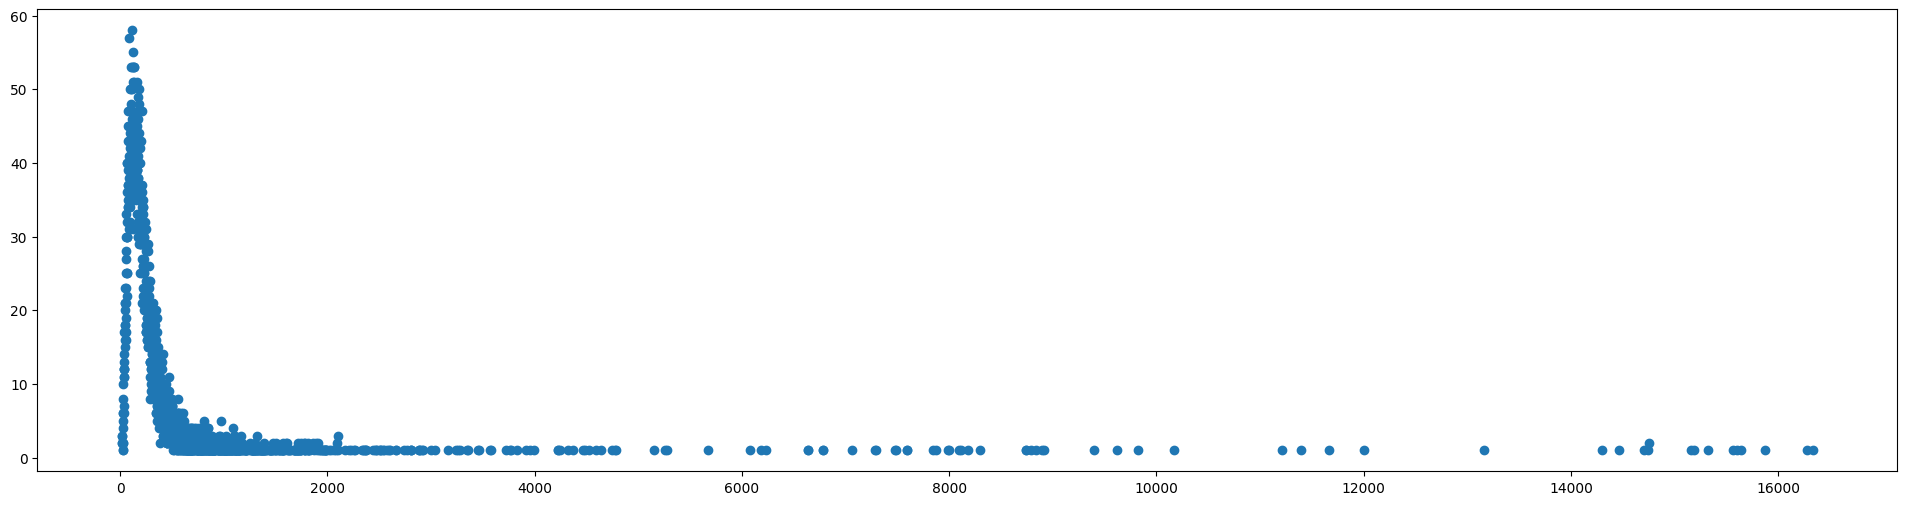

In [9]:
lengths=[len(seq) for seq in train_sequences]
lengths=dict(Counter(lengths))
plt.figure(figsize=[24,6])
plt.scatter(list(lengths.keys()), list(lengths.values()))
plt.show()

### Padeamos las secuencias pra que todas tengan el mismo largo
Así, la red tendra una dimension FIJA de input. Esto tambien es notable, nos da a entender que para estos modelos por mas que los textos sean mas cortos se extienden hasta llegar a una dimension fija. Este NO es el caso de las RNN, que se verán con mas profundidad en otros proyectos.

In [10]:
max_len=500
train_sequences=pad_sequences(train_sequences,maxlen=max_len)
test_sequences=pad_sequences(test_sequences,maxlen=max_len)


In [11]:
train_sequences[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
reverse_dictionary = token.index_word
dictionary = dict([(value, key) for (key, value) in reverse_dictionary.items()])


In [14]:
token.index_word

{1: 'UNK',
 2: 'the',
 3: 'to',
 4: 'of',
 5: 'a',
 6: "'ax",
 7: 'and',
 8: 'in',
 9: 'i',
 10: 'is',
 11: 'that',
 12: 'it',
 13: 'for',
 14: 'you',
 15: 'from',
 16: 'edu',
 17: 'on',
 18: 'this',
 19: 'be',
 20: 'are',
 21: 'not',
 22: 'have',
 23: 'with',
 24: 'as',
 25: '1',
 26: 'or',
 27: 'was',
 28: 'if',
 29: 'but',
 30: 'subject',
 31: 'they',
 32: 'com',
 33: 'lines',
 34: 'at',
 35: 'organization',
 36: 'by',
 37: '2',
 38: 'an',
 39: 'my',
 40: 'can',
 41: 'x',
 42: '3',
 43: 'what',
 44: '0',
 45: 'all',
 46: 'will',
 47: 'm',
 48: 'there',
 49: 'would',
 50: 'one',
 51: 'do',
 52: "'",
 53: 'about',
 54: 're',
 55: 'we',
 56: 'writes',
 57: 'so',
 58: 'he',
 59: 'your',
 60: 'no',
 61: 'has',
 62: 'article',
 63: 'any',
 64: 'me',
 65: 'some',
 66: 'who',
 67: 'out',
 68: 'which',
 69: '4',
 70: 'q',
 71: 'more',
 72: 'like',
 73: 'people',
 74: "don't",
 75: 'when',
 76: '5',
 77: 'just',
 78: 'university',
 79: 'posting',
 80: 'their',
 81: 'were',
 82: 'up',
 83: 'r'

### Cargamos embeddings pre entrenados.
En este caso, nos valemos de fasttext (https://fasttext.cc/), una dataset abierta de, justamente embeddings de 1M de palabras en ingles, cada una con dimension 300.

In [15]:
#load embeddings
EMBEDDING_DIR = "/content/drive/MyDrive/Colab Notebooks/"
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open(EMBEDDING_DIR+'wiki-news-300d-1M.vec', encoding='utf-8')
for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...
found 999995 word vectors


In [16]:
embeddings_index["car"]

array([-1.600e-02, -3.000e-04, -1.684e-01,  8.990e-02, -2.000e-02,
       -9.300e-03,  4.820e-02, -3.080e-02, -4.510e-02,  6.000e-04,
        1.680e-01,  9.650e-02,  3.061e-01, -4.110e-02,  2.960e-02,
       -4.630e-02,  3.250e-02, -7.030e-02,  2.220e-02, -1.404e-01,
       -2.638e-01, -1.340e-02,  1.277e-01,  1.227e-01,  1.803e-01,
       -1.920e-02,  3.530e-02,  1.214e-01,  1.509e-01, -8.610e-02,
        9.760e-02, -2.550e-02, -2.760e-02, -1.556e-01, -7.390e-02,
        5.430e-02, -6.700e-02, -3.000e-03,  1.515e-01,  6.080e-02,
        3.300e-02,  7.470e-02,  9.000e-04,  5.500e-02,  4.800e-03,
       -1.320e-02, -2.620e-02, -1.804e-01,  8.050e-02,  4.640e-02,
       -1.590e-02, -3.020e-02, -6.785e-01,  1.632e-01,  1.030e-02,
        6.550e-02, -8.430e-02,  2.270e-02,  3.350e-02, -3.560e-02,
       -6.380e-02, -1.111e-01, -1.700e-03,  9.780e-02,  5.650e-02,
       -3.520e-02,  3.950e-02,  1.867e-01,  7.900e-02, -1.234e-01,
        1.860e-02,  8.900e-02,  1.631e-01,  7.830e-02,  5.610e

In [17]:
embed_dim=300
num_words=len(dictionary)+1
embedding_matrix=np.zeros([num_words,embed_dim])
for word, idx in dictionary.items():
  if idx <= num_words and word in embeddings_index:
    embedding_matrix[idx,:]=embeddings_index[word]

### Loss
Para este problema vamos a utilizar la loss function conocida como Sparse Categorical Cross Entropy. En pocas palabras, resulta la mas adecuada para el problema de clasificación de clases mutuamente excluyentes y en el que los labels se presentan como un entero(ej:[3]), a diferencia de un one-hot encoded vector (p.ej;[0, 0, 1, 0])
Esto no es nada nuevo pero a modo de repaso sirve consultar las fuentes.

Link útil: https://rmoklesur.medium.com/what-you-need-to-know-about-sparse-categorical-cross-entropy-9f07497e3a6f

### El modelo mas "naive"
Se plantea un modelo simple, que consta de la capa inicial de embeddings, los cuales se suman (IMPORTANTE! Esto nos da como idea que es un approach de Bag Of Words, es decir que para este modelo NO IMPORTA EL ORDEN de los embeddings! Veremos mas adelante como afecta esto a la performance).
Luego solo hay una hidden layer con activacion 'relu' y, logicamente, la capa de salida, softmax de dimension 20 (esto será asi para todos los modelos, por supuesto).


# Suma de embeddings + MLP

In [18]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Lambda
from keras.models import Sequential,Model
from keras import optimizers
import keras.backend as K
nb_words=num_words
num_filters=64
model = Sequential()
model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))   #Los embeddings se definen como no entrenables, ya que se realizó previamente y nos valemos de los proveídos por fasttext
model.add(Lambda(lambda x: K.sum(x, axis=1)))
model.add(Dense(32, activation='relu'))
model.add(Dense(20, activation='softmax'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          40243200  
                                                                 
 lambda (Lambda)             (None, 300)               0         
                                                                 
 dense (Dense)               (None, 32)                9632      
                                                                 
 dense_1 (Dense)             (None, 20)                660       
                                                                 
Total params: 40253492 (153.55 MB)
Trainable params: 10292 (40.20 KB)
Non-trainable params: 40243200 (153.52 MB)
_________________________________________________________________


In [19]:
model.fit(train_sequences, newsgroups_train.target,batch_size=32,epochs=20,validation_split=0.2)

Epoch 1/20
283/283 [==============================] - 8s 10ms/step - loss: 4.3063 - accuracy: 0.1348 - val_loss: 2.6838 - val_accuracy: 0.1900
Epoch 2/20
283/283 [==============================] - 6s 20ms/step - loss: 2.4391 - accuracy: 0.2589 - val_loss: 2.2253 - val_accuracy: 0.3230
Epoch 3/20
283/283 [==============================] - 4s 13ms/step - loss: 1.9768 - accuracy: 0.3822 - val_loss: 1.7881 - val_accuracy: 0.4397
Epoch 4/20
283/283 [==============================] - 7s 24ms/step - loss: 1.5841 - accuracy: 0.4929 - val_loss: 1.5539 - val_accuracy: 0.4878
Epoch 5/20
283/283 [==============================] - 2s 8ms/step - loss: 1.3740 - accuracy: 0.5602 - val_loss: 1.3835 - val_accuracy: 0.5692
Epoch 6/20
283/283 [==============================] - 3s 11ms/step - loss: 1.2572 - accuracy: 0.6030 - val_loss: 1.2654 - val_accuracy: 0.6010
Epoch 7/20
283/283 [==============================] - 3s 9ms/step - loss: 1.1657 - accuracy: 0.6280 - val_loss: 1.2216 - val_accuracy: 0.6133
E


Los resultados no son tan buenos, ambas accuracies por debajo del 80%..

## Clasificador Embeddings + CNN

En este caso se reemplaza la etapa de "suma de embeddings" por un "bloque convolucional" (conjunto de capa convolucional, su posterior, pooling y de ser adecuado, regularizamos mediante dropout layers).
Hasta aqui sigue sin importar el orden, pero se tiene ahora relacion entre bloques de terminos (similar a cuando usabamos convoluciones en clasificación de imagenes, nos importaba reconocer objetos pero sin importar DONDE se ubican estos). Otro concepto que aprovechamos es el de usar mas de un filtro con la esperanza de que se adapten a diferentes "features" que pueda presentar nuestro texto.

Un poco mas de insight para la aplicacion de CNNs en NLP se puede encontrar en el siguiente articulo:
https://medium.com/@rachel_95942/convolutional-networks-for-nlp-54ff28fe9a91


In [20]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense
from keras.models import Sequential,Model
from keras import optimizers
nb_words=num_words
num_filters=64
model = Sequential()
model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters*2, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(20, activation='softmax'))  #multi-label (k-hot encoding)

adam = optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 300)          40243200  
                                                                 
 conv1d (Conv1D)             (None, 500, 64)           134464    
                                                                 
 max_pooling1d (MaxPooling1  (None, 250, 64)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 250, 128)          57472     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)              

In [21]:
model.fit(train_sequences, newsgroups_train.target,batch_size=32,epochs=20,validation_split=0.2)

Epoch 1/20
283/283 [==============================] - 18s 27ms/step - loss: 2.8485 - accuracy: 0.0914 - val_loss: 2.2362 - val_accuracy: 0.2528
Epoch 2/20
283/283 [==============================] - 24s 84ms/step - loss: 1.7077 - accuracy: 0.4070 - val_loss: 1.1393 - val_accuracy: 0.6412
Epoch 3/20
283/283 [==============================] - 14s 48ms/step - loss: 1.1101 - accuracy: 0.6182 - val_loss: 0.9456 - val_accuracy: 0.6894
Epoch 4/20
283/283 [==============================] - 6s 21ms/step - loss: 0.8382 - accuracy: 0.7209 - val_loss: 0.7511 - val_accuracy: 0.7676
Epoch 5/20
283/283 [==============================] - 13s 45ms/step - loss: 0.6658 - accuracy: 0.7781 - val_loss: 0.6687 - val_accuracy: 0.7941
Epoch 6/20
283/283 [==============================] - 8s 29ms/step - loss: 0.5580 - accuracy: 0.8168 - val_loss: 0.6218 - val_accuracy: 0.8047
Epoch 7/20
283/283 [==============================] - 12s 42ms/step - loss: 0.4448 - accuracy: 0.8537 - val_loss: 0.6010 - val_accuracy: 0

Notamos una mejora drástica en el accuracy de clasificacion de set de datos de entrenamiento, aunque la performance de validación difiera bastante. La conclusión mas natural de esta diferencia es, que estamos frente a un caso de overfitting a los datos de entrenamiento.

## Clasificación con TextCNN
Notando la mejora que implica la operación de la convolucion para el problema a resolver, se propone una primer mejora sobre esta misma. La idea del siguiente modelo es, si sabemos que con una capa convolucional vamos a analizar las palabras de a bloques de tamaño fijo a priori, podriamos establecer cierto paralelismo con el concepto de los "n-grams". Entonces, se plantea conectar a la capa de entrada 3 ramas de convoluciones con distinto tamaño, lo que les setea un campo perceptual distinto a cada una y por ende nos da maniobrabilidad en el largo que tiene la unidad basica de analisis. En menos palabras, una rama ve de a 2 palabras, otra de a 3 y otra de a 4, en este caso. Luego cada una cuenta con su pooling y los resultados son enfilados antes de ingresarse a las capas densas.

In [22]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Input, Concatenate
from keras.models import Model
from keras import optimizers
nb_words=num_words
num_filters=64
input_layer = Input(shape=(max_len,))
embedding_layer=Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)
conv4=Conv1D(num_filters, 4, activation='relu', padding='same')(embedding_layer)
conv3=Conv1D(num_filters, 3, activation='relu', padding='same')(embedding_layer)
conv2=Conv1D(num_filters, 2, activation='relu', padding='same')(embedding_layer)
pool4=GlobalMaxPooling1D()(conv4)
pool3=GlobalMaxPooling1D()(conv3)
pool2=GlobalMaxPooling1D()(conv2)
added = Concatenate()([pool4, pool3, pool2])
dense1=Dense(32, activation='relu')(added)
dense2=Dense(20, activation='softmax')(dense1)
model=Model(input_layer , dense2)
adam = optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])



In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 500, 300)             4024320   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 conv1d_2 (Conv1D)           (None, 500, 64)              76864     ['embedding_2[0][0]']         
                                                                                                  
 conv1d_3 (Conv1D)           (None, 500, 64)              57664     ['embedding_2[0][0]']     

In [24]:
model.fit(train_sequences, newsgroups_train.target,batch_size=32,epochs=20,validation_split=0.2)

Epoch 1/20
283/283 [==============================] - 11s 31ms/step - loss: 2.3058 - accuracy: 0.3229 - val_loss: 1.2654 - val_accuracy: 0.6991
Epoch 2/20
283/283 [==============================] - 21s 73ms/step - loss: 0.8399 - accuracy: 0.7762 - val_loss: 0.7017 - val_accuracy: 0.7972
Epoch 3/20
283/283 [==============================] - 9s 31ms/step - loss: 0.4740 - accuracy: 0.8711 - val_loss: 0.5758 - val_accuracy: 0.8303
Epoch 4/20
283/283 [==============================] - 18s 63ms/step - loss: 0.2956 - accuracy: 0.9253 - val_loss: 0.4919 - val_accuracy: 0.8555
Epoch 5/20
283/283 [==============================] - 10s 34ms/step - loss: 0.1812 - accuracy: 0.9657 - val_loss: 0.4546 - val_accuracy: 0.8617
Epoch 6/20
283/283 [==============================] - 12s 43ms/step - loss: 0.1077 - accuracy: 0.9870 - val_loss: 0.4364 - val_accuracy: 0.8736
Epoch 7/20
283/283 [==============================] - 33s 116ms/step - loss: 0.0616 - accuracy: 0.9961 - val_loss: 0.4330 - val_accuracy:

Aunque en principio parecia prometedor, no se observa mayor mejora en cuando a la performance final.

# Attention
Los modelos implementados hasta este punto tienen sus diferencias y similitudes, lo que arrojó por consecuente diferencias en cuanto a la performance de accuracy y tiempo de entrenamiento. Sin embargo uno de los avances mas grandes en el camino del desarollo de tecnicas para problemas de NLP tiene que ser la implementación de mecanismos de Attention.

No es el objetivo de este trabajo desarrollar al detalle la teoría, pero se puede comentar que, conceptualmente, este mecanismo sirve para dar un marco matemático que permita atribuir puntajes (o scores) de importante para los terminos mas relevantes en un corpus. Así, al momento de entrenar una red esta aprende a evaluar qué partes del texto están aportando mayor cantidad de información y en consecuencia fabricarse un contexto mas jugoso del cual se vale para la tarea en cuestión.

Algunas fuentes útiles que se usaron para desarrollar intuición sobre el concepto y pueden resultar de utilidad para repasar fueron:

Contexto y pantallazo breve: https://medium.com/one-minute-machine-learning/did-you-pay-attention-when-this-architecture-was-introduced-70f6f632364a

Un desarrollo con un poco mas de detalle: https://medium.com/@edloginova/attention-in-nlp-734c6fa9d983

Sabiendo que Attention es el "paso siguiente" de las redes con LSTMs, un poco de repaso de este ultimo para dejar planteado los problemas que supone no es muy descabellado:http://colah.github.io/posts/2015-08-Understanding-LSTMs/

y por supuesto el famoso paper "Attention Is All You Need" que es por muchos considerado el puntapié de la cuestión.



# MLP + Embeddings + Attention
Con los fundamentos de lo que implica agregar un mecanismo de Attention a nuestros modelos considerados, el primer modelo a tratar involucra agregarlo al primer modelo que vimos en el principio de esta Notebook.

In [25]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Input, Concatenate,Dot,RepeatVector,TimeDistributed,Multiply,Lambda,Flatten,Activation,Reshape
import keras.backend as K
from keras.activations import softmax
from keras.models import Model
from keras import optimizers

def softMaxOverTime(x):
    return softmax(x,axis=1)

key_dim=50
nb_words=num_words
num_filters=64
#1 Entrada de datos en formato de palabras
input_layer = Input(shape=(max_len,))
#2 Descomposicion de las palabras sus embeddings
embedding_layer=Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)
#3
dense_input=Dense(key_dim,activation="tanh")(embedding_layer)
#4
ulog_attention=Dense(1,activation="linear")(dense_input)
#5 obtención de scores (alphas)
attention=Activation(softMaxOverTime)(ulog_attention)

repeated_attention=TimeDistributed(RepeatVector(embed_dim))(attention)

repeated_attention=Reshape([max_len,embed_dim])(repeated_attention)

#6 Pesado de las palabras(sus vectores de embeddings) con los scores obtenidos
weighted_embeddings=Multiply()([repeated_attention,embedding_layer])
#7
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

#8 MLP
dense1=Dense(32, activation='relu')(embedding_sum)
#9 Softmax de salida
dense2=Dense(20, activation='softmax')(dense1)
model=Model(input_layer , dense2)
adam = optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


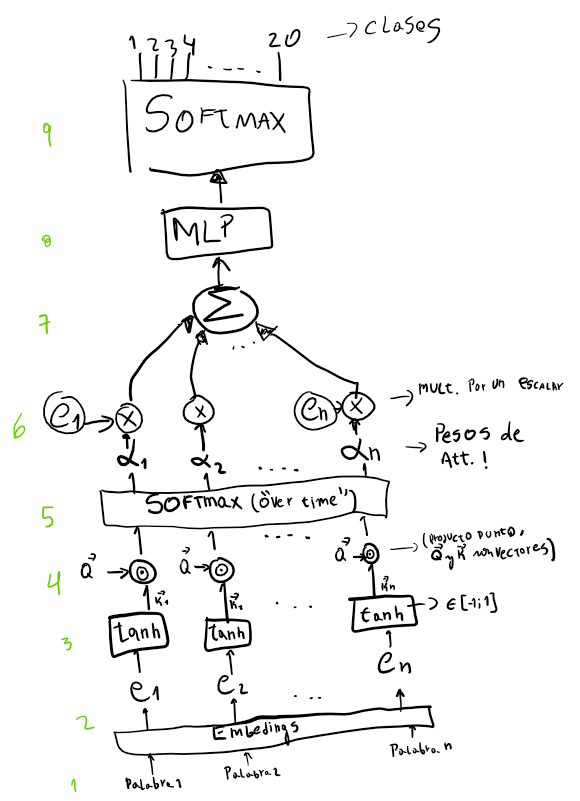

Se deja la imagen que intenta dar una representacion ordenada de los pasos que ocurren en el modelo para que incluya Attention.

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 500, 300)             4024320   ['input_2[0][0]']             
                                                          0                                       
                                                                                                  
 dense_6 (Dense)             (None, 500, 50)              15050     ['embedding_3[0][0]']         
                                                                                                  
 dense_7 (Dense)             (None, 500, 1)               51        ['dense_6[0][0]']       

In [27]:
model.fit(train_sequences, newsgroups_train.target,batch_size=32,epochs=30,validation_split=0.2)

Epoch 1/30
283/283 [==============================] - 12s 26ms/step - loss: 2.6302 - accuracy: 0.2219 - val_loss: 1.9059 - val_accuracy: 0.4441
Epoch 2/30
283/283 [==============================] - 8s 29ms/step - loss: 1.6705 - accuracy: 0.5027 - val_loss: 1.5282 - val_accuracy: 0.5351
Epoch 3/30
283/283 [==============================] - 6s 20ms/step - loss: 1.4093 - accuracy: 0.5788 - val_loss: 1.3020 - val_accuracy: 0.6222
Epoch 4/30
283/283 [==============================] - 7s 24ms/step - loss: 1.1541 - accuracy: 0.6629 - val_loss: 1.1121 - val_accuracy: 0.6717
Epoch 5/30
283/283 [==============================] - 5s 19ms/step - loss: 1.0094 - accuracy: 0.7056 - val_loss: 1.0032 - val_accuracy: 0.7017
Epoch 6/30
283/283 [==============================] - 6s 21ms/step - loss: 0.9236 - accuracy: 0.7270 - val_loss: 0.9456 - val_accuracy: 0.7172
Epoch 7/30
283/283 [==============================] - 5s 18ms/step - loss: 0.8643 - accuracy: 0.7429 - val_loss: 0.9141 - val_accuracy: 0.727

Para el epoch numero 20 notamos una mejora con respecto al modelo en cuanto a accuracy que se habia corrido al inicio, lo que nos denota la ventaja que supone agregar este mecanismo a la red! Se dejo correr por algunos epochs mas a fin de ver si habia mayores mejoras y aunque, siguio mejorando, el interes ahora será agregar Attention a otras arquitecturas.

# MLP + Embeddings + Attention + CNN

Agregamos attention ahora al modelo convolucional..

In [29]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Input, Concatenate,Dot,RepeatVector,TimeDistributed,Multiply,Lambda,Flatten, BatchNormalization
import keras.backend as K
from keras.activations import softmax
from keras.models import Model
from keras import optimizers
value_dim=100

def softMaxOverTime(x):
    return softmax(x,axis=1)


nb_words=num_words
num_filters=64
input_layer = Input(shape=(max_len,))
embedding_layer=Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)
conv_out=Conv1D(value_dim,8,padding="same")(embedding_layer)
conv_out=Activation("relu")(conv_out)
#conv_out=Conv1D(value_dim,8,activation="relu",padding="same")(conv_out)
conv_out=Conv1D(value_dim,8,activation="tanh",padding="same")(conv_out)
ulog_attention=Dense(1,activation="linear")(conv_out)
attention=Activation(softMaxOverTime)(ulog_attention)
repeated_attention=TimeDistributed(RepeatVector(value_dim))(attention)
repeated_attention=Reshape([max_len,value_dim])(repeated_attention)
weighted_embeddings=Multiply()([repeated_attention,conv_out])
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)
dense1=Dense(100, activation='relu')(embedding_sum)
dense2=Dense(20, activation='softmax')(dense1)
model=Model(input_layer , dense2)
adam = optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [30]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 500, 300)             4024320   ['input_4[0][0]']             
                                                          0                                       
                                                                                                  
 conv1d_7 (Conv1D)           (None, 500, 100)             240100    ['embedding_5[0][0]']         
                                                                                                  
 activation_3 (Activation)   (None, 500, 100)             0         ['conv1d_7[0][0]']      

In [31]:
model.fit(train_sequences, newsgroups_train.target,batch_size=32,epochs=50,validation_split=0.2)

Epoch 1/50
283/283 [==============================] - 21s 65ms/step - loss: 1.7555 - accuracy: 0.4127 - val_loss: 0.9668 - val_accuracy: 0.6805
Epoch 2/50
283/283 [==============================] - 20s 72ms/step - loss: 0.7678 - accuracy: 0.7423 - val_loss: 0.8066 - val_accuracy: 0.7366
Epoch 3/50
283/283 [==============================] - 32s 115ms/step - loss: 0.5467 - accuracy: 0.8154 - val_loss: 0.6871 - val_accuracy: 0.7768
Epoch 4/50
283/283 [==============================] - 25s 87ms/step - loss: 0.3928 - accuracy: 0.8693 - val_loss: 0.6806 - val_accuracy: 0.7981
Epoch 5/50
283/283 [==============================] - 13s 47ms/step - loss: 0.2728 - accuracy: 0.9147 - val_loss: 0.6887 - val_accuracy: 0.8073
Epoch 6/50
283/283 [==============================] - 27s 97ms/step - loss: 0.1875 - accuracy: 0.9404 - val_loss: 0.7155 - val_accuracy: 0.8259
Epoch 7/50
283/283 [==============================] - 18s 63ms/step - loss: 0.1289 - accuracy: 0.9609 - val_loss: 0.7646 - val_accuracy

En este modelo elemental notamos que no hay mejoras sustanciales con respecto al modelo probado con anterioridad que incluia redes convolucionales sin attention.

# Bidir RNN + Attention
Por ultimo se planteo un modelo con una RNN de tipo bidireccional, es decir que procesa los textos en ambos sentidos de forma recurrente. Para subsanar los problemas propios de la recurrencia, como son el vanishing y exploding gradient, se implementan con memoria de largo y corto plazo (LSTM).

Fuente útil: https://medium.com/analytics-vidhya/bi-directional-rnn-basics-of-lstm-and-gru-e114aa4779bb

In [35]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Input, Concatenate,Dot,RepeatVector,TimeDistributed,Multiply,Lambda,Bidirectional, LSTM
import keras.backend as K
from keras.activations import softmax
from keras.models import Model
from keras import optimizers
value_dim=100

def softMaxOverTime(x):
    return softmax(x,axis=1)

nb_words=num_words
num_filters=64
input_layer = Input(shape=(max_len,))
embedding_layer=Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)
# lstm_out=Bidirectional(LSTM(value_dim, return_sequences=True))(embedding_layer)
# lstm_out=Bidirectional(LSTM(value_dim, return_sequences=True))(lstm_out)
lstm_out=Bidirectional(LSTM(value_dim, return_sequences=True,activation="tanh"),merge_mode="sum")(embedding_layer)
ulog_attention=Dense(1,activation="linear")(lstm_out)
attention=Activation(softMaxOverTime)(ulog_attention)
repeated_attention=TimeDistributed(RepeatVector(value_dim))(attention)
repeated_attention=Reshape([max_len,value_dim])(repeated_attention)
weighted_embeddings=Multiply()([repeated_attention,lstm_out])
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)
dense1=Dense(100, activation='relu')(embedding_sum)
dense2=Dense(20, activation='softmax')(dense1)
model=Model(input_layer , dense2)
adam = optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])


In [36]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 embedding_7 (Embedding)     (None, 500, 300)             4024320   ['input_6[0][0]']             
                                                          0                                       
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 500, 100)             320800    ['embedding_7[0][0]']         
 onal)                                                                                            
                                                                                            

In [38]:
model.fit(train_sequences, newsgroups_train.target,batch_size=256,epochs=50,validation_split=0.2)

Epoch 1/50
36/36 [==============================] - 18s 484ms/step - loss: 2.8505 - accuracy: 0.1103 - val_loss: 2.6805 - val_accuracy: 0.1379
Epoch 2/50
36/36 [==============================] - 13s 376ms/step - loss: 2.5664 - accuracy: 0.1592 - val_loss: 2.4713 - val_accuracy: 0.1304
Epoch 3/50
36/36 [==============================] - 17s 479ms/step - loss: 2.3093 - accuracy: 0.2177 - val_loss: 2.2121 - val_accuracy: 0.2081
Epoch 4/50
36/36 [==============================] - 18s 501ms/step - loss: 2.1070 - accuracy: 0.2796 - val_loss: 1.9377 - val_accuracy: 0.3266
Epoch 5/50
36/36 [==============================] - 18s 525ms/step - loss: 1.9051 - accuracy: 0.3371 - val_loss: 1.8853 - val_accuracy: 0.3473
Epoch 6/50
36/36 [==============================] - 19s 526ms/step - loss: 1.7408 - accuracy: 0.3926 - val_loss: 1.6440 - val_accuracy: 0.4198
Epoch 7/50
36/36 [==============================] - 13s 366ms/step - loss: 1.5687 - accuracy: 0.4466 - val_loss: 1.5406 - val_accuracy: 0.4569

Para este caso final, las metricas bajaron con respecto a los mejores modelos planteados anteriormente. No solo eso, sino que tambien el tiempo de entrenamiento fue considerablemente mayor, lo que nos da a pensar que, a priori, no pareceria una buena idea reemplazarlos por esta ultima implementación.